## Import library

In [1]:
import os
os.environ['PATH'] += os.pathsep + '/home/jupyter-23522024/.local/bin'

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import time
import copy
import random
import shutil
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

## Setup dataset

- https://www.kaggle.com/datasets/jonathanrjpereira/rice-disease
- https://www.kaggle.com/datasets/badhon7432/paddyleafdiseaseuci

In [2]:
# !rm -r combined_dataset
# !rm -r final_dataset

In [3]:
# !unzip dataset_1.zip -d dataset_1
# clear_output()

In [4]:
# !unzip dataset_2.zip -d dataset_2
# clear_output()

Combine two datasets into one unified dataset with the following four classes:
- Healthy → from the first dataset
- Bacterial leaf blight → from train, val, and test folders of the second dataset
- Brown spot → from train, val, and test of the second dataset (ignore from first)
- Leaf smut → from train, val, and test of the second dataset

In [5]:
# Create the combined dataset directory
output_dir = "combined_dataset"
target_classes = ["Healthy", "Bacterial leaf blight", "Brown spot", "Leaf smut"]

for cls in target_classes:
    os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

In [6]:
# Copy Healthy class from first dataset
healthy_src = glob("dataset_1/Rice_All/Healthy/*")  # all image paths
for img_path in healthy_src:
    shutil.copy(img_path, os.path.join(output_dir, "Healthy"))

In [7]:
# Copy the other three classes from second dataset
second_dataset_dirs = ["dataset_2/train", "dataset_2/valid", "dataset_2/test"]
classes_to_copy = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

for cls in classes_to_copy:
    for folder in second_dataset_dirs:
        src = os.path.join(folder, cls)
        img_paths = glob(f"{src}/*")
        for img_path in img_paths:
            shutil.copy(img_path, os.path.join(output_dir, cls))

In [8]:
# Split Dataset into Fixed Train/Val/Test Folders
random.seed(42)  # Ensures reproducibility

def split_dataset(source_dir, target_dir, split_ratio=(0.8, 0.1, 0.1)):
    classes = os.listdir(source_dir)

    for cls in tqdm(classes):
        class_path = os.path.join(source_dir, cls)
        images = os.listdir(class_path)
        random.shuffle(images)

        n_total = len(images)
        n_train = int(split_ratio[0] * n_total)
        n_val = int(split_ratio[1] * n_total)

        splits = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for split, split_images in splits.items():
            split_folder = os.path.join(target_dir, split, cls)
            os.makedirs(split_folder, exist_ok=True)
            for img in split_images:
                shutil.copy(
                    os.path.join(class_path, img),
                    os.path.join(split_folder, img)
                )

split_dataset("combined_dataset", "final_dataset", split_ratio=(0.7, 0.15, 0.15))

100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


## EDA
### Class distribution

In [9]:
data_dir = "final_dataset/train"
classes = os.listdir(data_dir)

image_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}
df_counts = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Image Count'])
df_counts

,Image Count
Brown spot,265
Bacterial leaf blight,258
Healthy,366
Leaf smut,265


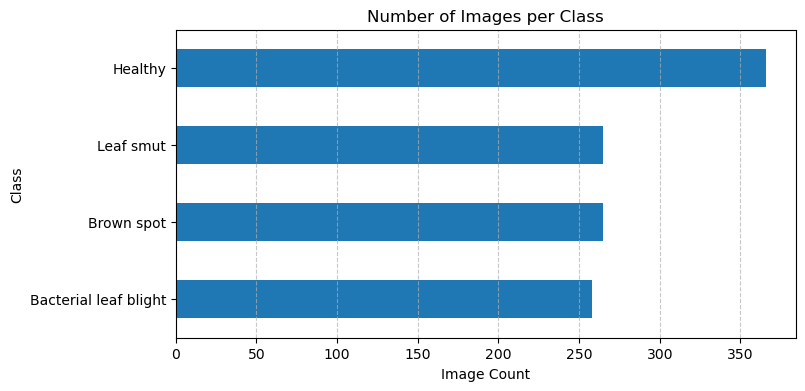

In [10]:
df_counts.sort_values('Image Count').plot(kind='barh', figsize=(8, 4), legend=False)
plt.title('Number of Images per Class')
plt.xlabel('Image Count')
plt.ylabel('Class')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### Visualize image samples

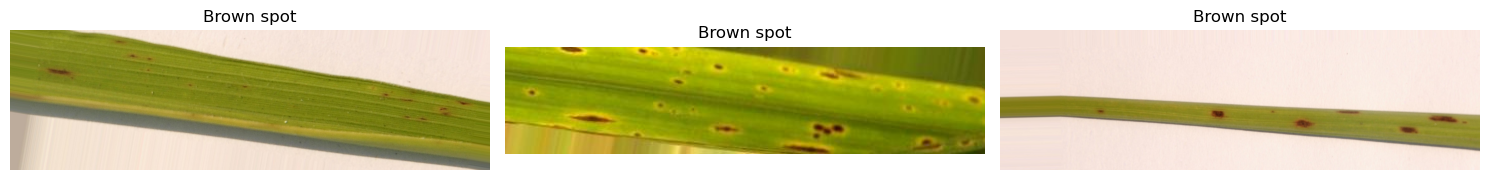

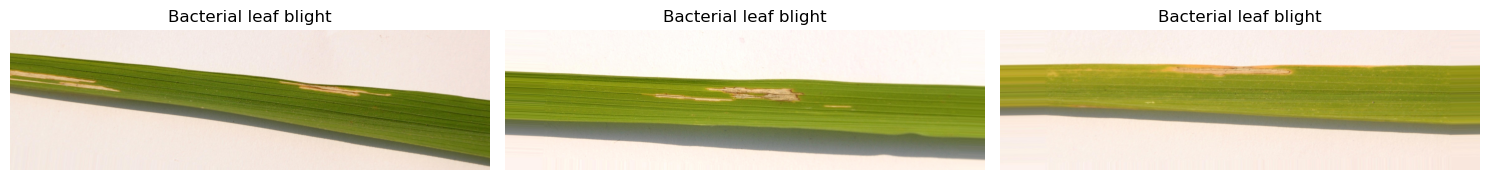

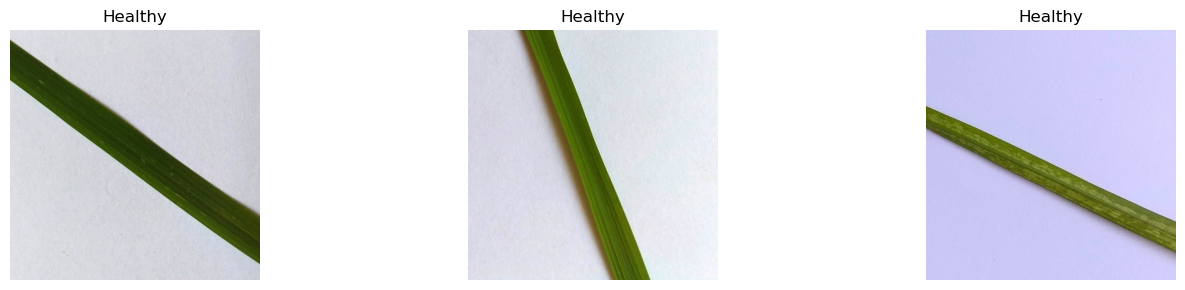

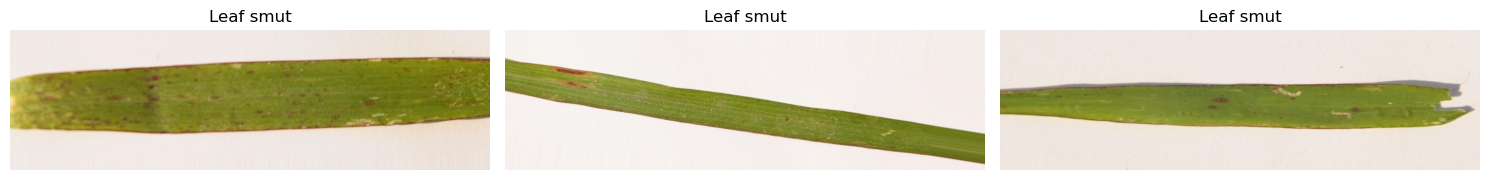

In [11]:
def show_random_images(base_dir, class_name, n=3):
    folder = os.path.join(base_dir, class_name)
    images = random.sample(os.listdir(folder), n)
    
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(images):
        img = cv2.imread(os.path.join(folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

for cls in classes:
    show_random_images(data_dir, cls)

## Build the model

### Data preprocessing
- Resize to 224x224 because models like ResNet and EfficientNet (B0) expect inputs to be 224×224 images by default
- Augmentation by flipping the image
- Converts from numpy array to tensor
- Normalizes each pixel value to be in the range [-1, 1] instead of [0, 1]

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ImageFolder used for:
# - It reads images inside bacterial/, brown spot/, healthy/ leaf smut/
# - It automatically labels them as: leaf blight: 0, brown spot: 1, etc.
# - It applies the transform_train to each image. So each sample in train_dataset becomes a (image_tensor, label) pair

train_ds = datasets.ImageFolder("final_dataset/train", transform=transform)
val_ds = datasets.ImageFolder("final_dataset/val", transform=transform)
test_ds = datasets.ImageFolder("final_dataset/test", transform=transform)

# DataLoader wraps a dataset:
# - Batches data (e.g., 32 images at a time)
# - Shuffles the data if needed
# - Enables efficient batch training and simplifies looping over the data

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

### Training functions 

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, model_name="model"):
    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 1.0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        train_correct, train_total, train_loss = 0, 0, 0

        train_pbar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)   # Forward pass → get predictions
            loss = criterion(outputs, labels)
            loss.backward()   # Compute gradients
            optimizer.step()   # Update weights

            # Calculate how many predictions are correct → for accuracy
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            train_pbar.set_postfix(loss=loss.item())   # Update progress bar with current loss

        train_acc = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct, val_total, val_loss = 0, 0, 0
        val_pbar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
            
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")        

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{model_name}_best.pth")  # Save to disk
            print(f"✅ Best model updated: Val Acc = {val_acc:.4f}")
        elif val_acc == best_acc and val_loss < best_loss:
            best_acc = val_acc
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f"{model_name}_best.pth")  # Save to disk
            print(f"✅ Best model updated: Val Acc = {val_acc:.4f}")
                    
    print(f"\n🎯 Best Val Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)  # Load best weights before returning
    return model, history

In [14]:
def plot_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

### ResNet model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
# # Vision Transformer
# model = models.vit_b_16(pretrained=True)
# model.heads.head = nn.Linear(model.heads.head.in_features, 4)

# Resnet
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [17]:
start_time = time.time()
model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=10,
    model_name='resnet18'
)
train_time = time.time() - start_time

print('Training Time (s):', train_time)


Epoch 1/10


Train Loss: 11.7513, Train Acc: 0.9003 | Val Loss: 0.1206, Val Acc: 1.0000
✅ Best model updated: Val Acc = 1.0000

Epoch 2/10


Train Loss: 0.8885, Train Acc: 0.9931 | Val Loss: 0.0247, Val Acc: 1.0000
✅ Best model updated: Val Acc = 1.0000

Epoch 3/10


Train Loss: 1.4146, Train Acc: 0.9913 | Val Loss: 0.0221, Val Acc: 1.0000
✅ Best model updated: Val Acc = 1.0000

Epoch 4/10


Train Loss: 0.9684, Train Acc: 0.9948 | Val Loss: 0.1380, Val Acc: 0.9959

Epoch 5/10


Train Loss: 3.2984, Train Acc: 0.9905 | Val Loss: 0.1921, Val Acc: 0.9959

Epoch 6/10


Train Loss: 2.2592, Train Acc: 0.9887 | Val Loss: 0.1639, Val Acc: 0.9918

Epoch 7/10


Train Loss: 2.1588, Train Acc: 0.9931 | Val Loss: 0.0178, Val Acc: 1.0000
✅ Best model updated: Val Acc = 1.0000

Epoch 8/10


Train Loss: 2.1274, Train Acc: 0.9870 | Val Loss: 0.0315, Val Acc: 1.0000

Epoch 9/10


Train Loss: 3.7964, Train Acc: 0.9974 | Val Loss: 0.0066, Val Acc: 1.0000
✅ Best model updated: Val Acc = 1.0000

Epoch 10/10


Train Loss: 1.4822, Train Acc: 0.9965 | Val Loss: 0.0328, Val Acc: 1.0000

🎯 Best Val Accuracy: 1.0000
Training Time (s): 354.1924452781677


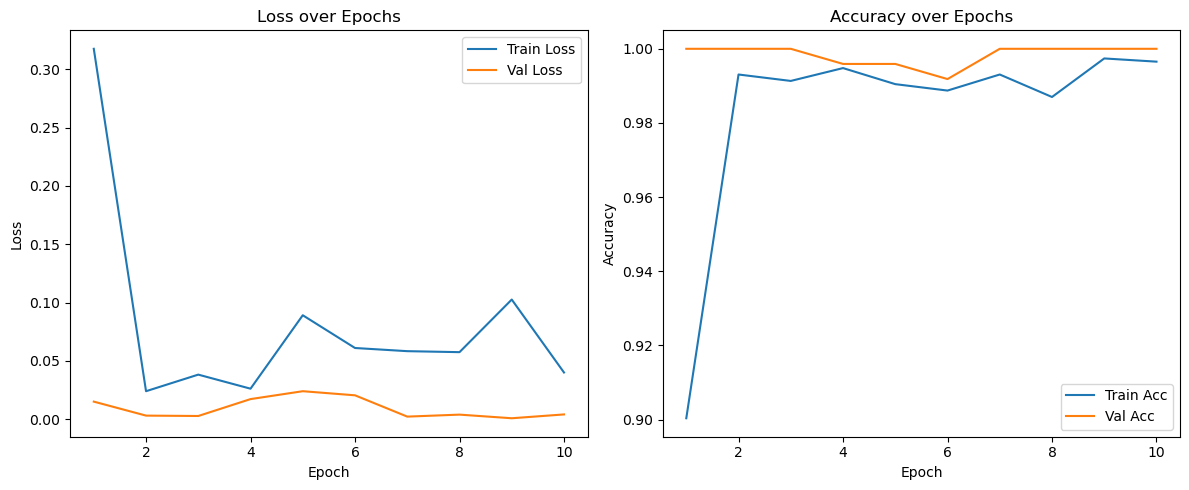

In [18]:
plot_training_curves(history)

## Inference

In [19]:
from PIL import Image

# Same transform used for validation/training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict_image(image_path, model, class_names):
    img_arr = Image.open(image_path).convert('RGB')
    input_tensor = transform(img_arr).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(predicted_class)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}")
    
    plt.tight_layout()
    plt.show()
    
    return predicted_class

In [20]:
loaded_model = models.resnet18(pretrained=False)
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 4)

loaded_model.load_state_dict(torch.load('resnet18_best.pth'))
loaded_model.to(device)
loaded_model.eval()

# Define class names in the same order as your training set folder
class_names = ['Bacterial Blight', 'Brown Spot', 'Healthy', 'Leaf Smut']

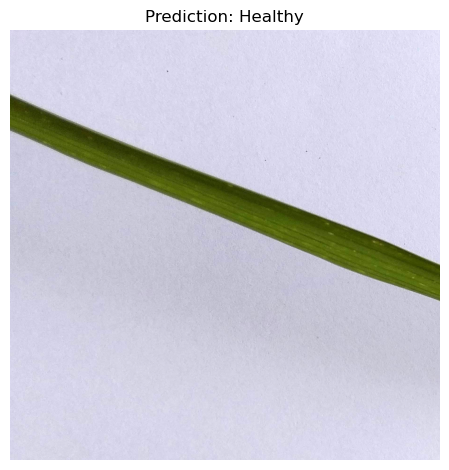

In [21]:
image_path = "./final_dataset/test/Healthy/IMG_20190419_101031.jpg"
prediction = predict_image(image_path, loaded_model, class_names)

In [22]:
# farrel/rice-disease-classification/final_dataset/test/Healthy/IMG_20190419_101031.jpg